# Experiment 3.1.3: Faithfulness of Effects, categorical

In [23]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torcheval.metrics.functional import r2_score

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr._utils.lrp_rules import EpsilonRule

#### Generate categorical data

In [24]:
def gen_data(levels, num_features=12, num_samples=5000):
    X_label = np.random.choice(levels, (num_samples, num_features))
    X = (X_label - (levels - 1) / 2) / ((levels - 1) / 2)
    X_one_hot = F.one_hot(torch.from_numpy(X_label)).numpy()
    
    X_one_hot_flattend = X_one_hot.reshape(X_one_hot.shape[0], -1)

    return X, X_label, X_one_hot_flattend

#### Calculate the Y with grouped beta for the categories mapped to real values

In [25]:
def calc_y(X, num_features, num_samples):
    epsilon = np.random.normal(0, 1, num_samples)

    beta = np.random.uniform(-1, 1, num_features + 1)
    beta[1:] = [0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.4, 0.4, 1, 1, 1, 1]

    Y = beta[0] + np.sum(np.multiply(beta[1:], X), axis=1) + epsilon

    return Y, beta

#### Define the neural network

In [26]:
class Net_label(nn.Module):

    def __init__(self, num_features):
        super(Net_label, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    
    def forward(self, input):
        return self.net(input)
    
class Net_encoding(nn.Module):

    def __init__(self, num_features, embedding_dim):
        super(Net_encoding, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(num_features * embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 1)
        )

    
    def forward(self, input):
        return self.net(input)

#### Split the data in train and test samples

In [27]:
def train_split(X, Y, num_samples, train_rate=0.80):

    index = int(num_samples * train_rate)

    X_train = X[:index]
    Y_train = Y[:index]

    X_test = X[index:]
    Y_test = Y[index:]

    return X_train, X_test, Y_train, Y_test

#### Train the network

In [28]:
def train_net(net, X_train, X_test, Y_train, Y_test):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    Y_train_tensor = torch.tensor(Y_train.reshape(-1, 1), dtype=torch.float32)

    highest_score = -10
    counter = 50
    PATH = "best_model_faith_cat.pt"

    for epoch in range(300):
        net.train()
        optimizer.zero_grad()
        outputs = net(X_train_tensor)
        loss = loss_fn(outputs, Y_train_tensor)
        loss.backward()
        optimizer.step()

        r2 = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

        if r2 > highest_score:
            highest_score = r2
            counter = 50
            torch.save(net.state_dict(), PATH)
        else:
            counter -= 1

        if counter == 0:
            break

    net.load_state_dict(torch.load(PATH, weights_only=True))
    net.eval()        

    score = r2_score(net.forward(torch.from_numpy(X_test).type(torch.FloatTensor)), torch.from_numpy(np.reshape(Y_test, (-1, 1))).type(torch.FloatTensor))

    return net, score

#### Generate the attribution values

In [29]:
def calc_explanations(net, test_input_tensor, X_test):

    test_input_tensor.requires_grad_()

    #Gradient

    sal = Saliency(net)

    attr_grad = sal.attribute(test_input_tensor, abs=False)
    attr_grad = attr_grad.detach().numpy()

    #Saliency

    attr_sal = np.square(attr_grad)

    #SmoothGrad

    sal = Saliency(net)
    nt = NoiseTunnel(sal)

    noise_level = 0.2
    stdev = (torch.max(test_input_tensor) - torch.min(test_input_tensor)).detach().item() * noise_level

    attr_sm_grad = nt.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev, abs=False)
    attr_sm_grad = attr_sm_grad.detach().numpy()

    #GradientxInput

    ixg = InputXGradient(net)

    attr_ixg = ixg.attribute(test_input_tensor)
    attr_ixg = attr_ixg.detach().numpy()

    #Lrp-epsilon

    net.net.rule = EpsilonRule(0.1)

    lrp = LRP(net)

    attr_lrp = lrp.attribute(test_input_tensor)
    attr_lrp = attr_lrp.detach().numpy()

    #SmoothGradXInput

    ixg = InputXGradient(net)
    nt_ixg = NoiseTunnel(ixg)

    attr_sm_ixg = nt_ixg.attribute(test_input_tensor, nt_samples=50, nt_type="smoothgrad", stdevs=stdev)
    attr_sm_ixg = attr_sm_ixg.detach().numpy()

    #Integrated Gradients

    ig = IntegratedGradients(net)

    attr_ig_zero = ig.attribute(test_input_tensor,baselines=0.0)
    attr_ig_zero = attr_ig_zero.detach().numpy()


    baseline_mean = torch.mean((test_input_tensor).type(torch.FloatTensor), dim=0, keepdim=True).type(torch.FloatTensor)

    ig = IntegratedGradients(net)

    attr_ig_mean = ig.attribute(test_input_tensor,baselines=baseline_mean)
    attr_ig_mean = attr_ig_mean.detach().numpy()
    
    #DeepLIFT

    dl = DeepLift(net)

    attr_dl_zero = dl.attribute(test_input_tensor, baselines=0.0)
    attr_dl_zero = attr_dl_zero.detach().numpy()

    dl = DeepLift(net)

    attr_dl_mean = dl.attribute(test_input_tensor, baselines=baseline_mean)
    attr_dl_mean = attr_dl_mean.detach().numpy()

    return attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean

#### Calculate the true feature effects from the categories mapped to real values

In [30]:
def calc_feature_importance(X_test, beta):
    feature_importance = np.multiply(beta[1:], X_test).T

    return feature_importance

#### Compute the correlation values

In [31]:
def correlations(attr, test_input_tensor, beta, num_features, feature_importance, embedding_dim):

    if attr.shape[1] > num_features:
        for j in range(num_features):
            attr[:,j] = np.sum(attr[:, (embedding_dim*j):(embedding_dim*(j+1))], axis=1)
    attr = attr[:,:num_features]

    explainations = attr.T

    corr_matrix = np.corrcoef(feature_importance, explainations)

    corr = [corr_matrix[i, num_features + i] for i in range(num_features)]

    return corr

#### Main method to conduct the simulation

In [32]:
num_features=12
num_samples=5000

data = []
for levels in [2, 4]:

    scores = []

    for i in range(200):

        X, X_label, X_onehot = gen_data(levels)

        Y, beta = calc_y(X, num_features, num_samples)

        X_train, X_test, Y_train, Y_test = train_split(X, Y, num_samples)

        feature_importance = calc_feature_importance(X_test, beta)


        if levels == 2:
            X_train, X_test, Y_train, Y_test = train_split(X_label, Y, num_samples)

            embedding_dim = int(len(X_train[0]) / num_features)
    
            net = Net_label(num_features)

        else:
            X_train, X_test, Y_train, Y_test = train_split(X_onehot, Y, num_samples)

            embedding_dim = int(len(X_train[0]) / num_features)

            net = Net_encoding(num_features, embedding_dim)


        test_input_tensor = torch.from_numpy(X_test).type(torch.FloatTensor)

        net, score = train_net(net, X_train, X_test, Y_train, Y_test)

        scores.append(score)

        #print(score)

        attr_grad, attr_sal, attr_sm_grad, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean = calc_explanations(
                                                                                            net, test_input_tensor, X_test)

        for (attr, corr_method) in zip((attr_grad, attr_sm_grad, attr_sal, attr_ixg, attr_lrp, attr_sm_ixg, attr_ig_zero, attr_ig_mean, attr_dl_zero, attr_dl_mean),
                                  ("Gradient", "SmoothGrad", "Saliency", "InputxGrad", "LRP-ℇ", "SmoothGradxInput", "Integrated Gradient(zero)", 
                                   "Integrated Gradient(mean)", "DeepLift(zero)", "DeepLift(mean)")):
    
            correlation = correlations(attr, X_test, beta, num_features, feature_importance, embedding_dim)

            for ind in range(len(correlation)):
                if ind < 4:
                    data.append({
                        'Method': corr_method,
                        'Levels': levels,
                        'FeatureEffect': "Weak",
                        'Correlation': correlation[ind]
                    })
                elif ind < 8:
                    data.append({
                        'Method': corr_method,
                        'Levels': levels,
                        'FeatureEffect': "Medium",
                        'Correlation': correlation[ind]
                    })
                else:
                    data.append({
                        'Method': corr_method,
                        'Levels': levels,
                        'FeatureEffect': "Strong",
                        'Correlation': correlation[ind]
                    })

    print(f"{levels} Levels: {np.mean(scores)}")

/opt/anaconda3/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


2 Levels: 0.8127028942108154
4 Levels: 0.7088214159011841


#### Plot the simulation results

               Method  Levels FeatureEffect  Correlation
0            Gradient       2          Weak    -0.774562
1            Gradient       2          Weak    -0.752564
2            Gradient       2          Weak    -0.762968
3            Gradient       2          Weak    -0.815435
4            Gradient       2        Medium    -0.817522
...               ...     ...           ...          ...
47995  DeepLift(mean)       4        Medium     0.992992
47996  DeepLift(mean)       4        Strong     0.998624
47997  DeepLift(mean)       4        Strong     0.997791
47998  DeepLift(mean)       4        Strong     0.998101
47999  DeepLift(mean)       4        Strong     0.997514

[48000 rows x 4 columns]


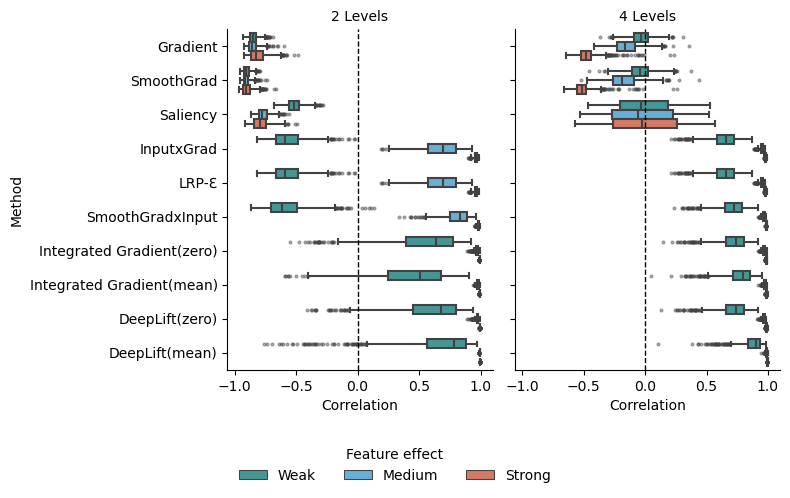

In [33]:

df = pd.DataFrame(data)
print(df)


flierprops = dict(marker='o', markersize=2, alpha=0.4)

g = sns.FacetGrid(
    df,
    col='Levels',
    sharex=True,
    height=5,
    aspect=0.8
)

g.map_dataframe(
    sns.boxplot,
    x='Correlation',
    y='Method',
    hue='FeatureEffect',
    palette={'Weak': '#39a3a3', 'Medium': '#56b4e9', 'Strong': '#e76f51'},
    flierprops=flierprops,
    dodge=True
)

for ax in g.axes.flatten():
    ax.axvline(0, color='black', linestyle='--', linewidth=1)

handles, labels = g.axes[0][0].get_legend_handles_labels()
g.figure.legend(handles, labels, title="Feature effect", loc='lower center', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0))

g.set_titles("{col_name} Levels")
plt.subplots_adjust(bottom=0.25)
plt.show()